In [102]:
import pandas as pd
import numpy as np
from collections import Counter 
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import pickle
import gc
import random
pd.set_option('display.max_colwidth', None)

import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

In [103]:
parent_dir = "/content/drive/MyDrive/AI/Colabs/CV/image-captioning/"
path = parent_dir + "using-RNN/flickr8k/"

dir = parent_dir + "using-Xformer/"

df = pd.read_csv(path + "captions.txt", sep=',')
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


In [104]:
def prepare_dataset(data):
  data = data.sort_values(by = 'image')
  train = data.iloc[: int(0.9 * len(data))]
  valid = data.iloc[int(0.9 * len(data)) :]

  print(len(train), train['image'].nunique())
  print(len(valid), valid['image'].nunique())

  train_imgs = train[['image']].drop_duplicates()
  valid_imgs = valid[['image']].drop_duplicates()
  print(len(train_imgs), len(valid_imgs))

  return train, valid, train_imgs, valid_imgs

In [105]:
def remove_single_char_word(word_list):
    lst = []

    for word in word_list:

        if len(word) <= 1:
            continue
        lst.append(word)

    return lst

In [106]:
def remove_alpha_and_single_word(data):
    # Add SOS and EOS to the beginning and end each caption. And if a word is not an alpha word, don't add it.
    data['cleaned_caption'] = data['caption'].apply(lambda caption : ['<start>'] + [word.lower() if word.isalpha() else '' for word in caption.split(" ")] + ['<end>'])
    
    # Remove single word captions (Not sure this is necessary though)
    data['cleaned_caption']  = data['cleaned_caption'].apply(lambda x : remove_single_char_word(x))

    return data

In [107]:
def get_max_seq_len(data):
  data = remove_alpha_and_single_word(data)
  data['seq_len'] = data['cleaned_caption'].apply(lambda x : len(x))
  max_seq_len = data['seq_len'].max()

  data.drop(['seq_len'], axis = 1, inplace = True)

  return max_seq_len

In [108]:
class Vocabulary():
  def __init__(self, data):
    self.data = data
    self.vocab_size = None
    self.stoi = {}
    self.itos = {}

  def remove_alpha_and_single_word(self):
    self.data = remove_alpha_and_single_word(self.data)

  def build_vocab(self, max_seq_len):
    self.remove_alpha_and_single_word()

    # Use the max len to add paddings to the all the captions
    self.data['cleaned_caption'] = self.data['cleaned_caption'].apply(lambda caption : caption + ['<pad>'] * (max_seq_len - len(caption)))
    display(df.head(2))

    word_list = self.data['cleaned_caption'].apply(lambda x : " ".join(x)).str.cat(sep = ' ').split(' ')
    word_dict = Counter(word_list)
    word_dict =  sorted(word_dict, key=word_dict.get, reverse=True)

    self.vocab_size = len(word_dict)

    # 
    self.itos = {index: word for index, word in enumerate(word_dict)}
    self.stoi = {word: index for index, word in enumerate(word_dict)}

    self.data['text_seq']  = self.data['cleaned_caption'].apply(lambda caption : [self.stoi[word] for word in caption] )

In [109]:
class FlickrDataset():
    def __init__(self, data, pkl_file, max_seq_len):
        self.data = data
        self.encodedImgs = pd.read_pickle(dir + pkl_file)
        self.vocab = Vocabulary(data)
        self.vocab.build_vocab(max_seq_len)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
    
        image_tensor, caption_seq = self.get_image_caption_pair(idx)
        target_seq = caption_seq[1:] + [0]

        image_tensor = image_tensor.permute(0, 2, 3, 1)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))

        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

    def get_image_caption_pair(self, idx):
        caption_seq = self.data.iloc[idx]['text_seq']
        image_name = self.data.iloc[idx]['image']

        try:
          image_tensor = self.encodedImgs[image_name]
        except:
          image_tensor, caption_seq = self.get_image_caption_pair(idx + 1)

        return image_tensor, caption_seq


In [110]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [111]:
class TransformImage():
    def __init__(self, data):
        self.data = data 
        self.scaler = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()
        
    def __len__(self):  
        return len(self.data)

    def __getitem__(self, idx):
        image_name, img = self.get_image(idx)
        transformed_img = self.normalize(self.to_tensor(self.scaler(img)))

        return image_name, transformed_img

    def get_image(self, idx):
        image_name = self.data.iloc[idx]['image']
        img_loc = path + 'images/' + str(image_name)
        
        try:
          img = Image.open(img_loc)
        except:
          print(f"The image {image_name} is not found.")
          image_name, img = self.get_image(idx + 1)

        return image_name, img

In [112]:
'''
  Load the pretrained model
'''
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18.eval()
resnet18_layer4 = resnet18._modules.get('layer4').to(device)

list(resnet18._modules)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [113]:
'''
  Get image embeddings using the pretrained model
'''
def get_embedding(transformed_image):
  transformed_image = Variable(transformed_image)
  embedding = torch.zeros(1, 512, 7, 7)
  def copy_data(m, i, o):
      embedding.copy_(o.data)
  
  h = resnet18_layer4.register_forward_hook(copy_data)
  resnet18(transformed_image)
  
  h.remove()
  return embedding

In [114]:
'''
  Extract image features using the pretrained model
'''
def get_image_features(image_dataloader):
  image_features = {}
  for image_name, transformed_image in tqdm(image_dataloader):
      transformed_image = transformed_image.to(device)
      embeddings = get_embedding(transformed_image)
      image_features[image_name[0]] = embeddings

  return image_features

In [115]:
train_data, val_data, train_images, val_images = prepare_dataset(df)
max_seq_len = get_max_seq_len(train_data)

36409 7282
4046 810
7282 810


In [116]:
train_image_transform = TransformImage(train_images)
train_image_dataloader = DataLoader(train_image_transform, batch_size=1, shuffle=False)

val_image_transform = TransformImage(val_images)
val_image_dataloader = DataLoader(val_image_transform, batch_size=1, shuffle=False)

In [117]:
"""Save the extracted features in pickle files"""

# pickle_file = open(dir + "EncodedImageTrainResNet.pkl", "wb")
# train_image_features = get_image_features(train_image_dataloader)
# pickle.dump(train_image_features, pickle_file)
# pickle_file.close()

# pickle_file = open(dir + "EncodedImageValidResNet.pkl", "wb")
# val_image_features = get_image_features(val_image_dataloader)
# pickle.dump(val_image_features, pickle_file)
# pickle_file.close()

'Save the extracted features in pickle files'

In [118]:
train_dataset = FlickrDataset(train_data, 'EncodedImageTrainResNet.pkl', max_seq_len)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = FlickrDataset(val_data, 'EncodedImageValidResNet.pkl', max_seq_len)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .


In [119]:
train_dataset.vocab.data.head()

,image,caption,cleaned_caption,text_seq
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 43, 3, 94, 171, 6, 120, 51, 399, 11, 366, 3, 28, 4864, 659, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 19, 316, 64, 194, 114, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,"[<start>, little, girl, climbing, into, wooden, playhouse, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 39, 19, 120, 64, 194, 2296, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .,"[<start>, little, girl, climbing, the, stairs, to, her, playhouse, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 39, 19, 120, 4, 366, 18, 60, 2296, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .,"[<start>, little, girl, in, pink, dress, going, into, wooden, cabin, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 39, 19, 3, 94, 171, 316, 64, 194, 2783, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [120]:
val_dataset.vocab.data.head()

,image,caption,cleaned_caption,text_seq
36406,436015762_8d0bae90c3.jpg,a man walking around the corner of a red building .,"[<start>, man, walking, around, the, corner, of, red, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 11, 44, 104, 4, 483, 10, 21, 134, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
36410,436393371_822ee70952.jpg,A brown doberman is outside with a stick in its mouth .,"[<start>, brown, doberman, is, outside, with, stick, in, its, mouth, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 25, 1144, 6, 80, 8, 107, 3, 74, 70, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
36411,436393371_822ee70952.jpg,A brown dog shows his teeth .,"[<start>, brown, dog, shows, his, teeth, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 25, 7, 771, 36, 528, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
36412,436393371_822ee70952.jpg,a dog bites a stick .,"[<start>, dog, bites, stick, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 7, 529, 107, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
36413,436393371_822ee70952.jpg,A dog is biting a twig .,"[<start>, dog, is, biting, twig, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 7, 6, 276, 1145, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


Build Transformer Model

---



In [121]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[: x.size(0), : , : ]
        
        # print(f"Size of x is {x.shape}")
        x = x + self.pe
        return self.dropout(x)

In [122]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()

        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model=embedding_size, nhead=n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer=self.TransformerDecoderLayer, num_layers=n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1, 0, 2)
        
        decoder_inp_embed = self.embedding(decoder_inp) * math.sqrt(self.embedding_size)
        
        # print(f"Size of decoder_inp_embed is {decoder_inp_embed.shape}")
        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)

        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)
        
        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)
        
        final_output = self.last_linear_layer(decoder_output)

        return final_output, decoder_input_pad_mask

In [128]:
EPOCH = 40
min_val_loss = np.float('Inf')

model = ImageCaptionModel(n_head=16, n_decoder_layer=4, vocab_size=train_dataset.vocab.vocab_size, embedding_size=512).to(device)

optimizer = optim.Adam(model.parameters(), lr = 1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=2, verbose=True)
criterion = nn.CrossEntropyLoss(reduction='none')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Model Training

---



In [129]:
def train_cycle(model, criterion, total_epoch_train_loss, total_train_words, epoch):
  model.train()
  for caption_seq, target_seq, image_embed in train_dataloader:
      optimizer.zero_grad()

      image_embed = image_embed.squeeze(1).to(device)
      caption_seq, target_seq = caption_seq.to(device), target_seq.to(device)

      output, padding_mask = model(image_embed, caption_seq)
      output = output.permute(1, 2, 0)

      loss = criterion(output, target_seq)

      loss_masked = torch.mul(loss, padding_mask)

      final_batch_loss = torch.sum(loss_masked) / torch.sum(padding_mask)

      final_batch_loss.backward()
      optimizer.step()

      total_epoch_train_loss += torch.sum(loss_masked).detach().item()
      total_train_words += torch.sum(padding_mask)

  print(f"End of train epoch {epoch}")
  return total_epoch_train_loss, total_train_words

In [130]:
def eval_cycle(model, criterion, total_epoch_val_loss, total_val_words, total_epoch_train_loss, epoch):
  model.eval()
  with torch.no_grad():
      for caption_seq, target_seq, image_embed in val_dataloader:

          image_embed = image_embed.squeeze(1).to(device)
          caption_seq, target_seq = caption_seq.to(device), target_seq.to(device)

          print(f"eval_cycle:: shape of caption_seq is {caption_seq.shape}")
          output, padding_mask = model(image_embed, caption_seq)
          output = output.permute(1, 2, 0)

          loss = criterion(output, target_seq)

          loss_masked = torch.mul(loss, padding_mask)

          total_epoch_val_loss += torch.sum(loss_masked).detach().item()
          total_val_words += torch.sum(padding_mask)

          total_epoch_val_loss /= total_val_words
      
          print("Epoch -> ", epoch," Training Loss -> ", total_epoch_train_loss.item(), "Eval Loss -> ", total_epoch_val_loss.item() )
        
          if min_val_loss > total_epoch_val_loss:
              print("Writing Model at epoch ", epoch)
              torch.save(model, dir + 'ic_model')
              min_val_loss = total_epoch_val_loss
        

          scheduler.step(total_epoch_val_loss.item())

      print(f"End of eval epoch {epoch}")


In [131]:
def train_model(model, criterion):
    for epoch in tqdm(range(EPOCH)):
      
        total_epoch_train_loss = 0
        total_train_words = 0
        total_epoch_train_loss, total_train_words = train_cycle(model, criterion, total_epoch_train_loss, total_train_words, epoch)
        total_epoch_train_loss = total_epoch_train_loss/total_train_words

        total_epoch_val_loss = 0
        total_val_words = 0
        eval_cycle(model, criterion, total_epoch_val_loss, total_val_words, total_epoch_train_loss, epoch)

Model Evaluation

---



In [132]:
train_model(model, criterion)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/40 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
eval_cycle:: shape of caption_seq is torch.Size([32, 33])
Epoch ->  20  Training Loss ->  4.399655342102051 Eval Loss ->  0.08509885519742966
eval_cycle:: shape of caption_seq is torch.Size([32, 33])
Epoch ->  20  Training Loss ->  4.399655342102051 Eval Loss ->  0.07764635980129242
eval_cycle:: shape of caption_seq is torch.Size([32, 33])
Epoch ->  20  Training Loss ->  4.399655342102051 Eval Loss ->  0.08939623832702637
eval_cycle:: shape of caption_seq is torch.Size([32, 33])
Epoch ->  20  Training Loss ->  4.399655342102051 Eval Loss ->  0.08743569999933243
eval_cycle:: shape of caption_seq is torch.Size([32, 33])
Epoch ->  20  Training Loss ->  4.399655342102051 Eval Loss ->  0.08111122995615005
eval_cycle:: shape of caption_seq is torch.Size([32, 33])
Epoch ->  20  Training Loss ->  4.399655342102051 Eval Loss ->  0.06715676933526993
eval_cycle:: shape of caption_seq is torch.Size([32, 33])
Epoch ->  20  Training Loss ->  4.39965

Inference

---



In [ ]:
model = torch.load(dir + 'ic_model')

start_token = val_dataset.vocab.stoi['<start>']
end_token = val_dataset.vocab.stoi['<end>']
pad_token = val_dataset.vocab.stoi['<pad>']

max_seq_len = 33
print(start_token, end_token, pad_token)

val_image_embedding = pd.read_pickle(dir + "EncodedImageValidResNet.pkl")

1 2 0


In [ ]:
def generate_caption(K, image_name): 
    image_loc = path + 'images/' + str(image_name)
    image = Image.open(image_loc).convert("RGB")
    plt.imshow(image)

    model.eval() 
    val_image_df = val_data[val_data['image'] == image_name]
    print("Actual Caption : ")
    print(val_image_df['caption'].tolist())

    image_embedding = val_image_embedding[image_name].to(device)
    image_embedding = image_embedding.permute(0,2,3,1)
    image_embedding = image_embedding.view(image_embedding.size(0), -1, image_embedding.size(3))

    input_seq = [pad_token] * max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):
            output, padding_mask = model.forward(image_embedding, input_seq)
            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]
            next_word = val_dataset.vocab.itos[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index

            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    print("\n")
    print("Predicted caption : ")
    print(" ".join(predicted_sentence+['.']))

Actual Caption : 
['Young child in pink top and purple pants clutching a turquoise guard rail .', 'A very young girl is walking on a playground .', 'The little girl is playing at the playground .', 'A little girl in pink and purple stands on a playground .', 'A female toddler wearing a pink shirt is playing on a playground .']


Predicted caption : 
are in playing his is walking on the large .


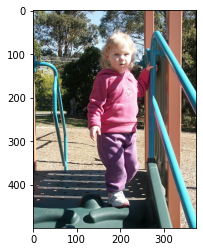

In [ ]:
generate_caption(1, val_images.iloc[50]['image'])